In [1]:
#!/usr/bin/python
#dbr 08/29/2024

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
import matplotlib.cm as cm
import seaborn as sns

sns.set_style("ticks")



In [2]:
#get other info for each ppts

df = pd.read_csv('data/sep2023-update/wideout.csv')

clindf = df.groupby('short_id').first().reset_index()

df.head()

,Unnamed: 0,short_id,agemo_at_ART,f/m,ARTregimen,time_ART_mo,log10VL,cens_vl,log10CD4,log10int,cens_intact,log10def,log10ratio
0,0,1,6.279452,0.0,0.0,1.380822,4.094646,0,NaN,3.091223,0,3.242724,-0.151501
1,1,1,6.279452,0.0,0.0,3.320548,2.732394,0,NaN,NaN,0,NaN,NaN
2,2,1,6.279452,0.0,0.0,5.523288,2.633468,0,3.240799,2.695703,0,2.971935,-0.276233
3,3,1,6.279452,0.0,0.0,8.284932,2.638489,0,NaN,NaN,0,NaN,NaN
4,4,1,6.279452,0.0,0.0,13.873973,2.667453,0,NaN,NaN,0,NaN,NaN


In [3]:
#info for TCR sequence participants

spidTCR=[49,73,78,116,134] #short ids

ts=[41,99,40,98,43,99,41,96,40,96] #sample months

#not naive data
fns=[
    '49_M41_NN.csv',
    '49_M99_NN.csv',
    '73_M40_NN.csv',
    '73_M98_NN.csv',
    '78_M43_NN.csv',
    '78_M99_NN.csv',
    '116_M41_NN.csv',
    '116_M96_NN.csv',
    '134_M40_NN.csv',
    '134_M96_NN.csv'
]


In [4]:
#function to calculate ecology

def calc_ecol(rsa):
    
    N = sum(rsa)
    R = sum(rsa>0)

    #now quickly look at ecology at second time point
    maxcl = max(rsa) #max clone size
    fcl = np.sum(rsa[rsa>1]) #fraction clonal (non-singleton)
    
    pa = rsa[rsa>0]/N
    
    D0=R/N
    D1=np.exp(-np.sum(pa*np.log(pa)))/N
    D2=1/np.sum(pa**2)/N
    
    return N,R,D0,D1,D2

#N,R,D0,D1,D2 = calc_ecol(rsa)

In [26]:
czTCR=['indigo','crimson','pink','purple','teal']


54988 20511 48837 18299
61288 22735 48022 18412
53569 4904 45036 4257
52832 23560 40680 17284
51902 7445 44719 6433


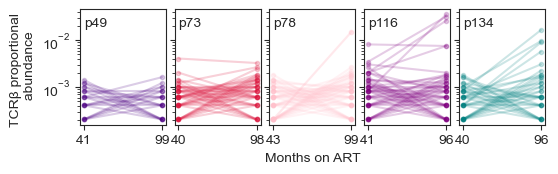

In [38]:
# get rate change in pa

set0to1=False #what to do with zero abundance observations?
global_ss=True #keep same sample size for everyone, smallest 4900

rcl=[]; rcstats=[] #rate change lists
foldchangel=[]
ecol_t1t2=[]
ecol_dynamics=[]
ssl=[]
appears_l=[]; disappears_l=[]; persists_l=[]

fig,axs=plt.subplots(1,5,figsize=(6,1.5),sharex=False,sharey=True)

original_l=[]

for ip,pid in enumerate(spidTCR):
    
    df1 = pd.read_csv('data/cleanTCR/'+fns[2*ip]) 
    df2 = pd.read_csv('data/cleanTCR/'+fns[2*ip+1]) 
    
    #resample these to same!
    N1=np.sum(df1['templates']); #sample size originally
    N2=np.sum(df2['templates']); #sample size originally
    
    R1=len(df1['templates'])
    R2=len(df2['templates'])
    
    original_l.append([N1,R1,N2,R2])
    
    print(N1,N2,R1,R2)
    df1['pa'] = df1['templates']/np.sum(df1['templates']) #original proportional abundance
    df2['pa'] = df2['templates']/np.sum(df2['templates']) #original proportional abundance
        
    if global_ss:
        ss=4900 #use global minimum
    else:
        ss=np.min([N1,N2]) #use minimum from this ppt
    ssl.append(ss)
    
    #resample to same size!
    df1['rsa'] = np.random.multinomial(n=ss,pvals=df1['pa']) #resampled abundance
    df2['rsa'] = np.random.multinomial(n=ss,pvals=df2['pa']) #resampled abundance

    dt12 = pd.merge(df1, df2, how='outer', on=['extended_rearrangement']) #choose this one for only those found at both

    lod=0 #can be zero!
    #lod=1/ss
    #dt12 = dt12.dropna() 
    dt12 = dt12.fillna(lod) #assume 0 is just undetectable
    
    dt12 = dt12[(dt12['rsa_x'] != 0) | (dt12['rsa_y'] != 0)] #drop rows where both are zero (ie one is nonzero)

    #collect those that either appeared, disappeared, or persisted
    appears_l.append(dt12[(dt12['rsa_x'] == 0) & (dt12['rsa_y'] > 0)]['rsa_y'])
    disappears_l.append(dt12[(dt12['rsa_x'] > 0) & (dt12['rsa_y'] == 0)]['rsa_x'])
    persists_l.append(dt12[(dt12['rsa_x'] > 0) & (dt12['rsa_y'] > 0)][['rsa_x','rsa_y']])
    
    #want total number of types persisting
    clones_a=len(appears_l[ip])
    clones_d=len(disappears_l[ip])
    clones_p=len(persists_l[ip])

    #want total number of types persisting
    cells_a=sum(appears_l[ip])
    cells_d=sum(disappears_l[ip])
    cells_p=sum(persists_l[ip]['rsa_y'])-sum(persists_l[ip]['rsa_x'])
    
    #also track fold changes by assuming LOD is 1/sample size
    pai=dt12['rsa_x'].values/ss; paf=dt12['rsa_y'].values/ss; pai[pai==0]=1/ss; paf[paf==0]=1/ss
    
    #assume exponential model, pF = p0*exp(r*Dt), so calc is: r = ln(pF/p0)/Dt
    #or alternatively assume linear
    #rc = (paf-pai)/(ts[2*ip+1]-ts[2*ip]) 
    rc = np.log(paf/pai)/(ts[2*ip+1]-ts[2*ip]) 
    rcstats.append([np.mean(rc),np.std(rc)])
    rcl.append(rc)
    
    #fold changes, simpler...
    foldchange = paf/pai 
    foldchangel.append(foldchange)
    
    N_t1,R_t1,D0_t1,D1_t1,D2_t1 = calc_ecol(dt12['rsa_x'])
    N_t2,R_t2,D0_t2,D1_t2,D2_t2 = calc_ecol(dt12['rsa_y'])
    
    #add to big lists
    ecol_t1t2.append([N_t1,R_t1,D0_t1,D1_t1,D2_t1,N_t2,R_t2,D0_t2,D1_t2,D2_t2])
    ecol_dynamics.append([pid,ts[2*ip],ts[2*ip+1],clones_a,clones_d,clones_p,cells_a,cells_d,cells_p,np.mean(rc),np.std(rc)])
    
    ### PLOT
    rsas = dt12[['rsa_x','rsa_y']]
    #axs[ip].boxplot([(rsas['rsa_x']+1)/ss,(rsas['rsa_y']+1)/ss],positions=[0,1],showfliers=False,widths=0.7)
    
    rsas = rsas.drop_duplicates() #just plot unique rows as lines
    for i in range(len(rsas)):
        axs[ip].semilogy([0,1],[(rsas['rsa_x'].iloc[i]+1)/ss,(rsas['rsa_y'].iloc[i]+1)/ss],marker='.',
                         color=czTCR[ip],alpha=0.2)

    axs[ip].annotate('p'+str(pid),[0,0.02],fontsize=10)

    axs[ip].set_xticks([0,1],[ts[2*ip],ts[2*ip+1]])
#plt.ylim([-4,20])
axs[2].set_xlabel('Months on ART')
#plt.ylim([2e-5,5e-2])
#plt.xlim([-0.1,1.1])
axs[0].set_ylabel('TCRβ proportional \n abundance')
plt.subplots_adjust(wspace=0.1)
plt.savefig('figures/TCR-allclones.pdf',dpi=600)


In [88]:
np.array(original_l)[:,1]/np.array(original_l)[:,0]

array([0.88813923, 0.78354653, 0.84071011, 0.76998789, 0.86160456])

In [89]:
np.array(original_l)[:,3]/np.array(original_l)[:,2]

array([0.89215543, 0.80985265, 0.86806688, 0.7336163 , 0.86406985])

Text(0, 0.5, 'Richness, R')

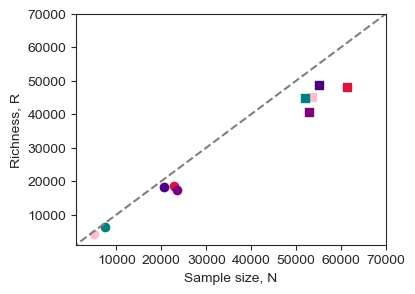

In [51]:
plt.figure(figsize=(4,3))

for i in range(5):
    plt.scatter(original_l[i][0],original_l[i][1],marker='s',color=czTCR[i])
    plt.scatter(original_l[i][2],original_l[i][3],marker='o',color=czTCR[i])
    
plt.plot([1,1e5],[1,1e5],ls='--',color='gray')

plt.xlim([1e3,7e4])
plt.ylim([1e3,7e4])

plt.xlabel('Sample size, N')
plt.ylabel('Richness, R')

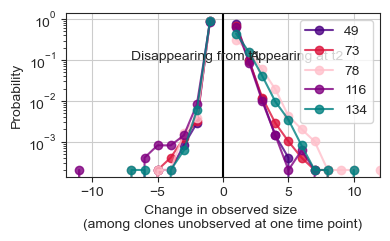

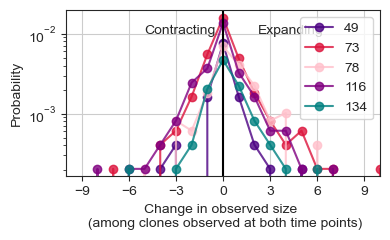

In [53]:
#look at distribution of expansions/contractions, of those that were unobserved

plt.figure(figsize=(4,2.5))
for i in range(5):
    #plt.subplot(211)
    y,x=np.histogram(appears_l[i],bins=np.arange(100))
    #plt.hist(appears_l[i],bins=np.arange(10),width=0.3,alpha=0.5,color=czl[i])
    plt.plot(x[1:-1],y[1:]/ss,alpha=0.8,color=czTCR[i],marker='o')
    plt.xlabel('Sampled size')
        
    #plt.subplot(212)
    #plt.hist(-disappears_l[i],bins=np.arange(-10,0),width=0.3,alpha=0.5,color=czl[i])
    y,x=np.histogram(-disappears_l[i],bins=np.arange(-100,0))
    plt.plot(x[1:],y/ss,alpha=0.8,color=czTCR[i],label=spidTCR[i],marker='o')

plt.annotate('Appearing at t2',[2,1e-1])
plt.annotate('Disappearing from t1',[-7,1e-1])
plt.xlabel('Change in observed size \n(among clones unobserved at one time point)')
plt.xlim([-20,65])
plt.axvline(0,color='k')
plt.ylabel('Probability')
plt.semilogy()
plt.grid('on')
plt.legend()
plt.tight_layout()
plt.savefig('figures/TCR-changestounobserved.pdf',dpi=600)

plt.xticks(np.arange(-15,15,5))
plt.xlim([-12,12])
plt.savefig('figures/TCR-changestounobserved-zoom.pdf',dpi=600)

#among persistent ones

plt.figure(figsize=(4,2.5))
for i in range(5):
    y,x=np.histogram((persists_l[i]['rsa_y']-persists_l[i]['rsa_x']),bins=np.arange(-100,100))
    plt.plot(x[:-1],y/ss,alpha=0.8,color=czTCR[i],marker='o',label=spidTCR[i],)
plt.semilogy()
plt.annotate('Contracting',[-5,1e-2])
plt.annotate('Expanding',[2.2,1e-2])

plt.xlabel('Change in observed size \n (among clones observed at both time points)')
plt.xlim([-15,52])
plt.axvline(0,color='k')
plt.ylabel('Probability')
plt.grid('on')
plt.legend()
plt.tight_layout()
plt.savefig('figures/TCR-observed.pdf',dpi=600)

plt.xticks(np.arange(-21,21,3))
plt.xlim([-10,10])
plt.savefig('figures/TCR-observed-zoom.pdf',dpi=600)


/var/folders/yk/0drxrmsj07l2thjtfhfyxcxh0000gn/T/ipykernel_59562/1537964283.py:20: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


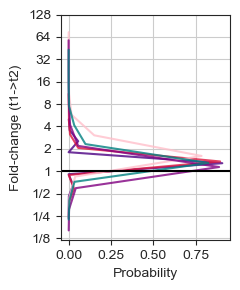

In [76]:
#Fold changes, also flipped y axis

plt.figure(figsize=(2.5,3))
for i in range(5):
    #plt.subplot(211)
    
    x,y = np.histogram(np.log2(foldchangel[i]))#,bins=np.arange(-5,5,1))

    plt.plot(x/sum(x),y[1:],alpha=0.8,color=czTCR[i])#,marker='o')
        
plt.yticks(np.arange(-3,8,1),['1/8','1/4','1/2','1','2','4','8','16','32','64','128'])
plt.axhline(0,color='k')
plt.xlabel('Probability')
plt.xticks(np.arange(0,1,0.25))
plt.ylabel('Fold-change (t1->t2)')
plt.grid('on')
plt.tight_layout()
plt.savefig('figures/TCRfold-observed.pdf',dpi=600)

plt.tight_layout()

In [66]:
ss

4900

In [58]:
np.arange(-5,6,1)

array([-5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5])

In [78]:
#mean across all ppts

CWHm=np.mean(np.array(rcstats)[:,0])
CWHs=np.mean(np.array(rcstats)[:,1])

print(np.log(2)/CWHm,np.log(2)/(CWHm+1.96*CWHs),np.log(2)/(CWHm-1.96*CWHs))

719.7838013724462 59.83533923065112 -71.76731566695781


In [79]:
ecol_df = pd.DataFrame(ecol_dynamics,columns=['short_id','t1','t2','clones_appear','clones_disappear','clones_persist',
                                      'cells_appear','cells_disappear','cells_persist',
                                      'mean_ratechange','std_ratechange'])

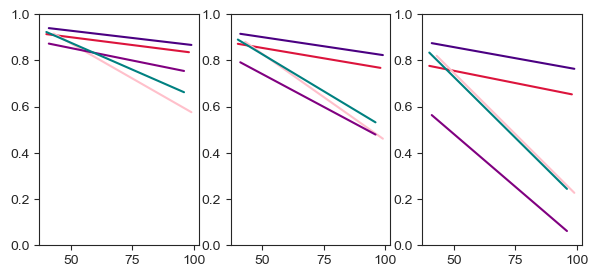

In [81]:
ecol_df2 = pd.DataFrame(ecol_t1t2,columns=['N_t1','R_t1','D0_t1','D1_t1','D2_t1','N_t2','R_t2','D0_t2','D1_t2','D2_t2'])

plt.figure(figsize=(7,3))
for i in range(5):
    plt.subplot(131)
    plt.plot([ecol_df['t1'].iloc[i],ecol_df['t2'].iloc[i]],[ecol_df2['D0_t1'].iloc[i],ecol_df2['D0_t2'].iloc[i]],color=czTCR[i])
    plt.ylim([0,1])
    
    plt.subplot(132)
    plt.plot([ecol_df['t1'].iloc[i],ecol_df['t2'].iloc[i]],[ecol_df2['D1_t1'].iloc[i],ecol_df2['D1_t2'].iloc[i]],color=czTCR[i])
    plt.ylim([0,1])
    
    plt.subplot(133)
    plt.plot([ecol_df['t1'].iloc[i],ecol_df['t2'].iloc[i]],[ecol_df2['D2_t1'].iloc[i],ecol_df2['D2_t2'].iloc[i]],color=czTCR[i])
    plt.ylim([0,1])


In [82]:
ecol_df2

,N_t1,R_t1,D0_t1,D1_t1,D2_t1,N_t2,R_t2,D0_t2,D1_t2,D2_t2
0,4903.0,4609,0.940037,0.915458,0.875067,4906.0,4255,0.867305,0.823421,0.763936
1,4910.0,4488,0.914053,0.872152,0.776653,4916.0,4109,0.835842,0.768050,0.653376
2,4902.0,4493,0.916565,0.880864,0.820281,4932.0,2841,0.576034,0.461441,0.226988
3,4917.0,4293,0.873093,0.792206,0.563682,4907.0,3703,0.754636,0.479369,0.061722
4,4900.0,4524,0.923265,0.890550,0.834185,4902.0,3248,0.662587,0.532218,0.244026


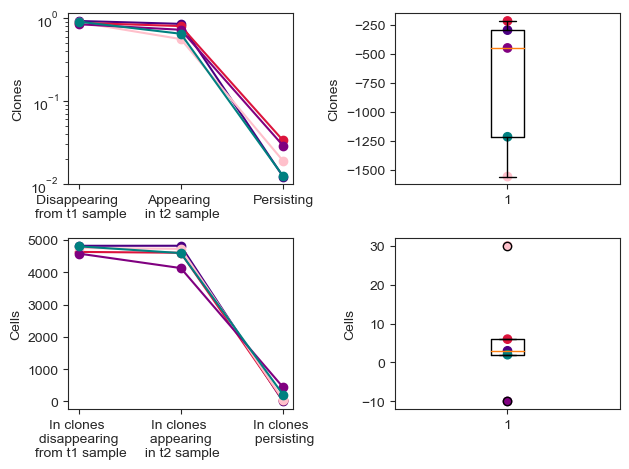

In [83]:
for i in range(5):
    tdf=ecol_df[ecol_df['short_id']==spidTCR[i]].iloc[0]
    
    plt.subplot(221)
    plt.plot([1,2,3],np.array([tdf['clones_disappear'],tdf['clones_appear'],tdf['clones_persist']])/ss,color=czTCR[i],marker='o',label=spidTCR[i])
    plt.xticks([1,2,3],['Disappearing \n from t1 sample','Appearing \n in t2 sample','Persisting'])
    plt.semilogy()
    plt.ylabel('Clones')
    
    plt.subplot(223)
    plt.plot([1,2,3],[tdf['cells_disappear'],tdf['cells_appear'],tdf['cells_persist']],color=czTCR[i],marker='o',label=spidTCR[i])
    plt.xticks([1,2,3],['In clones \n disappearing \n from t1 sample','In clones \n appearing \n in t2 sample','In clones \n persisting'])
    #plt.semilogy()
    plt.ylabel('Cells')
    
plt.subplot(222)
tot=ecol_df['clones_appear']-ecol_df['clones_disappear']+ecol_df['clones_persist']
plt.scatter(np.ones(5),tot,c=czTCR)
plt.boxplot(tot)
plt.ylabel('Clones')

plt.subplot(224)
tot=ecol_df['cells_appear']-ecol_df['cells_disappear']+ecol_df['cells_persist']
plt.scatter(np.ones(5),tot,c=czTCR)
plt.boxplot(tot)
plt.ylabel('Cells')

plt.tight_layout()

In [85]:
for i in range(5):
    tdf=ecol_df[ecol_df['short_id']==spidTCR[i]].iloc[0]
    print(tdf['clones_persist']/ss)

0.012244897959183673
0.03346938775510204
0.018979591836734692
0.028979591836734694
0.012448979591836735


In [13]:
#the fraction that are new at the second time point

tdf

short_id             134.000000
t1                    40.000000
t2                    96.000000
clones_appear       3152.000000
clones_disappear    4457.000000
clones_persist        78.000000
cells_appear        4574.000000
cells_disappear     4792.000000
cells_persist        221.000000
mean_ratechange        0.001542
std_ratechange         0.006333
Name: 4, dtype: float64

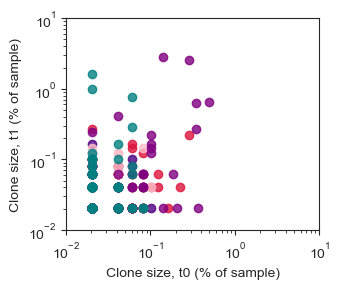

In [14]:
#clone size correlation among persistent

plt.figure(figsize=(3.5,3))
for i in range(5):
    plt.scatter(persists_l[i]['rsa_x']/ss*100,persists_l[i]['rsa_y']/ss*100,alpha=0.8,color=czl[i],marker='o',label=spidTCR[i])
plt.loglog()
plt.xlim([0.01,10])
plt.ylim([0.01,10])

#sns.regplot(persists_l[i]['rsa_x']/ss*100,persists_l[i]['rsa_y']/ss*100,marker='',color='gray')

plt.ylabel('Clone size, t1 (% of sample)')
plt.xlabel('Clone size, t0 (% of sample)')
plt.tight_layout()
plt.savefig('figures/TCR-xy.pdf',dpi=600)

#xs=np.linspace(0.01,0.99)
#plt.plot(xs*100,0.1*np.sqrt(1-xs**2)*100)


In [15]:
#get mean and sd rates from monolix

#go through and get individual estimates

pdf=pd.read_csv('monolix/splitV<1/IndividualParameters/estimatedIndividualParameters.txt')
pdf = pdf[['id','thV1_mean','thV1_sd', 'thV2_mean','thV2_sd']]

pdf=pdf.rename(columns={'thV1_mean':'RNA<1(1)',
                        'thV1_sd':'RNA<1(1)_sd',
                        'thV2_mean':'RNA<1(2)',
                         'thV2_sd':'RNA<1(2)_sd'})

thnames = ['RNA>1','Intact<1','Defective<1','Intact>1','Defective>1','CD4<1','CD4>1']

for im, mname in enumerate(['splitV>1','splitI<1','splitD<1','splitI>1','splitD>1','splitS<1','splitS>1']):
    pdfi = pd.read_csv('monolix/'+mname+'/IndividualParameters/estimatedIndividualParameters.txt')
    pdfi = pdfi[['id','thV1_mean','thV1_sd']]
    pdfi = pdfi.rename(columns={'thV1_mean': thnames[im],'thV1_sd': thnames[im]+'_sd' })

    pdf = pd.merge(pdf,pdfi,on='id',how='outer')

pdf.head()

pdf['short_id']=pdf['id']
pdf.columns

Index(['id', 'RNA<1(1)', 'RNA<1(1)_sd', 'RNA<1(2)', 'RNA<1(2)_sd', 'RNA>1',
       'RNA>1_sd', 'Intact<1', 'Intact<1_sd', 'Defective<1', 'Defective<1_sd',
       'Intact>1', 'Intact>1_sd', 'Defective>1', 'Defective>1_sd', 'CD4<1',
       'CD4<1_sd', 'CD4>1', 'CD4>1_sd', 'short_id'],
      dtype='object')

In [16]:
#merge TCR ecology and individual estimates
mdf = pd.merge(pdf,ecol_df,on='short_id',how='inner')


In [17]:
#look at correaltions with decay rates

ecolnms = ['N','R','D0','D1','D2','clones_appear',
       'clones_disappear', 'clones_persist', 'cells_appear', 'cells_disappear',
       'cells_persist', 'mean_ratechange', 'std_ratechange']

poprates = ['Intact>1', 'Defective>1','CD4>1']

corrdf = mdf.corr(method='spearman')
sns.heatmap(corrdf.loc[poprates,ecolnms,],annot=True,cmap='vlag',vmin=-1,vmax=1)

KeyError: "['N', 'R', 'D0', 'D1', 'D2'] not in index"

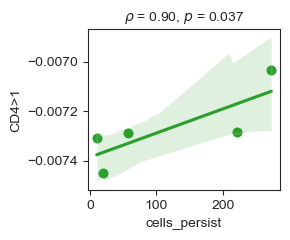

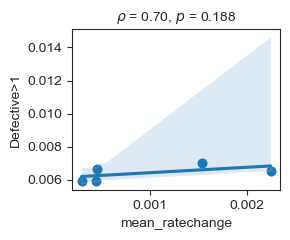

In [18]:
#any interesting cases?

ol=[['CD4>1','cells_persist'],
    ['Defective>1','mean_ratechange']   ]

czl=['tab:green','tab:blue']

for i,oi in enumerate(ol):
    
    o1=oi[0]; o2=oi[1]

    tdf = mdf[[o1,o2]].dropna()
    x,y= tdf[o2],-tdf[o1]
    #x,y=-np.log(2)/tdf[o1],np.log(2)/tdf[o2]
    rho,pval=st.spearmanr(x,y)

    #print(rho,pval)
    plt.figure(figsize=(3,2.5))
    plt.scatter(x=x,y=y,marker='o',color=czl[i])#,alpha=0.5)    
    sns.regplot(x=x,y=y,marker='o',color=czl[i])#,alpha=0.5)    
    #plt.title(r'$r$ = {:.2f}'.format(rho) + r', $p$ = {:.3f}'.format(pval))
    plt.title(r'$\rho$ = {:.2f}'.format(rho) + r', $p$ = {:.3f}'.format(pval),fontsize=10)
    #plt.semilogy()
    #plt.xlabel(o1+'\n half-life (months)')
    #plt.ylabel(o2+'\n half-life (months)')
    #plt.xticks(np.arange(-0.35,-0.21,0.03))
    #plt.xlim([-0.34,-0.2])
    #plt.ylim([0.01,0.07])
    plt.tight_layout()
    plt.savefig('figures/corrTCR'+o1+o2+'.pdf',dpi=600)



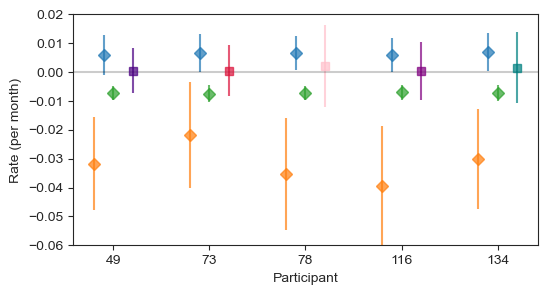

In [92]:
#plot differences
jit=0.02

plt.figure(figsize=(6,3))
czl=['tab:orange','tab:blue','tab:green','k']
for io,o in enumerate(['Intact>1', 'Defective>1', 'CD4>1']):
    plt.errorbar(np.arange(5)+io/10,-mdf[o],yerr=1.96*mdf[o+'_sd'],ls='',marker='D',color=czl[io],label=o,alpha=0.7)

for i in range(5):
    #plt.scatter(np.random.normal(i+4/10,jit,len(rcl[i])),rcl[i],c='gray',alpha=0.1,s=1)
    plt.errorbar(i+4/10,np.mean(rcl[i]),yerr=1.96*np.std(rcl[i]),ls='',marker='s',color=czTCR[i],alpha=0.7,label='TCR clonotypes')
    
    #plt.boxplot(np.log10(foldchangel[i]),positions=[i],showmeans=False,showfliers=False)
#plt.semilogy()
#plt.yticks(np.log10([1/128,1/64,1/32,1/16,1/8,1/4,1/2,1,2,4,8,16,32,64,128]),['1/128','1/64','1/32','1/16','1/8','1/4','1/2','1','2','4','8','16','32','64','128'])
#plt.axhline(0,ls='--',color='gray',alpha=0.5)
plt.xticks(np.arange(5)+0.2,spidTCR)
#plt.tight_layout()

#plt.legend(loc=2,ncol=2)
plt.xlabel('Participant')
plt.ylabel('Rate (per month)')
plt.ylim([-0.06,0.02])
plt.axhline(0,color='k',alpha=0.2)
plt.savefig('figures/TCR-comparerates.pdf',dpi=600)
